# Saber Detection

In [1]:
import cv2
import imageio
import numpy as np
import plotly.express as px

def load_image(idx=0):
    # *** first and last channels were swapped when using OPENCV functions ***
    vid = imageio.get_reader("test_video.mp4",  'ffmpeg')
    vid_iter = vid.iter_data()
    for _ in range(idx+1):
        image = next(vid_iter)
    return image

test_frames = (51, 56, 78, 104, 174, 454)
idx = test_frames[0]

# settings for Hough Lines P
rho = 1                         # distance resolution in pixels of the Hough grid
theta = np.pi / 180             # angular resolution in radians of the Hough grid
threshold = 40                  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 25            # minimum number of pixels making up a line
max_line_gap = 10               # maximum gap in pixels between connectable line segments

img = load_image(idx)
print(img.mean(axis=(0, 1)))

/home/martin/.local/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


[163.47721463 100.92952799  29.3776161 ]


### Method 1: BGR thresholding and Hough Lines P

In [ ]:
# reload image to ensure reset when running cell
img = load_image(idx)

# convert to HSV for simplicity
blur = cv2.GaussianBlur(img, (3, 3), 0)
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
blur = cv2.filter2D(blur, ddepth=-1, kernel=kernel)
m1 = blur[:, :, 1] > 200
m2 = blur[:, :, 2] > 200
m3 = blur[:, :, 0] > 240
mask = (m1 + m2 + m3).astype(np.uint8)

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(mask, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

gray = np.zeros(img.shape[:2], np.uint8)
if isinstance(lines, np.ndarray):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(gray, (x1, y1), (x2, y2), 255, 2)
            length = abs(x1 - x2) + abs(y1 - y2)
            if 100 > length > 40:
                centroid = (int((x1 + x2) / 2), int((y1 + y2) / 2))
                cv2.drawMarker(img, centroid, (0, 255, 0),
                               markerType=cv2.MARKER_CROSS, thickness=2)

# contours, _ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# for i, contour in enumerate(contours):
#     if 800 > cv2.contourArea(contour) > 60:
#         cv2.drawContours(img, contours, i, 255, -1)
        
px.imshow(img)

### Method 2: Combine BGR and HSV masks

In [ ]:
# reload image to ensure reset when running cell
img = load_image(idx)

b = (img[:, :, 0] > 200).astype(int)
r = (img[:, :, 2] > 220).astype(int)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

v = (hsv[:, :, 2] > 210).astype(int)
s = cv2.inRange(hsv[:, :, 1],  140, 175)

m1 = np.logical_and(b, s)
m2 = np.logical_and(r, v)
mask = (m1 + m2).astype(np.uint8)

rho = 1                         # distance resolution in pixels of the Hough grid
theta = np.pi / 180             # angular resolution in radians of the Hough grid
threshold = 40                  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 25            # minimum number of pixels making up a line
max_line_gap = 15               # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(mask, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

gray = np.zeros(img.shape[:2], np.uint8)
if isinstance(lines, np.ndarray):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(gray, (x1, y1), (x2, y2), 255, 2)
            x_diff = x1 - x2
            y_diff = y1 - y2
            centroid = (int((x1 + x2) / 2), int((y1 + y2) / 2))
            cv2.drawMarker(img, centroid, (0, 255, 0),
                           markerType=cv2.MARKER_CROSS, thickness=1)
        
px.imshow(img)

### Feature detection speed comparison

In [2]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


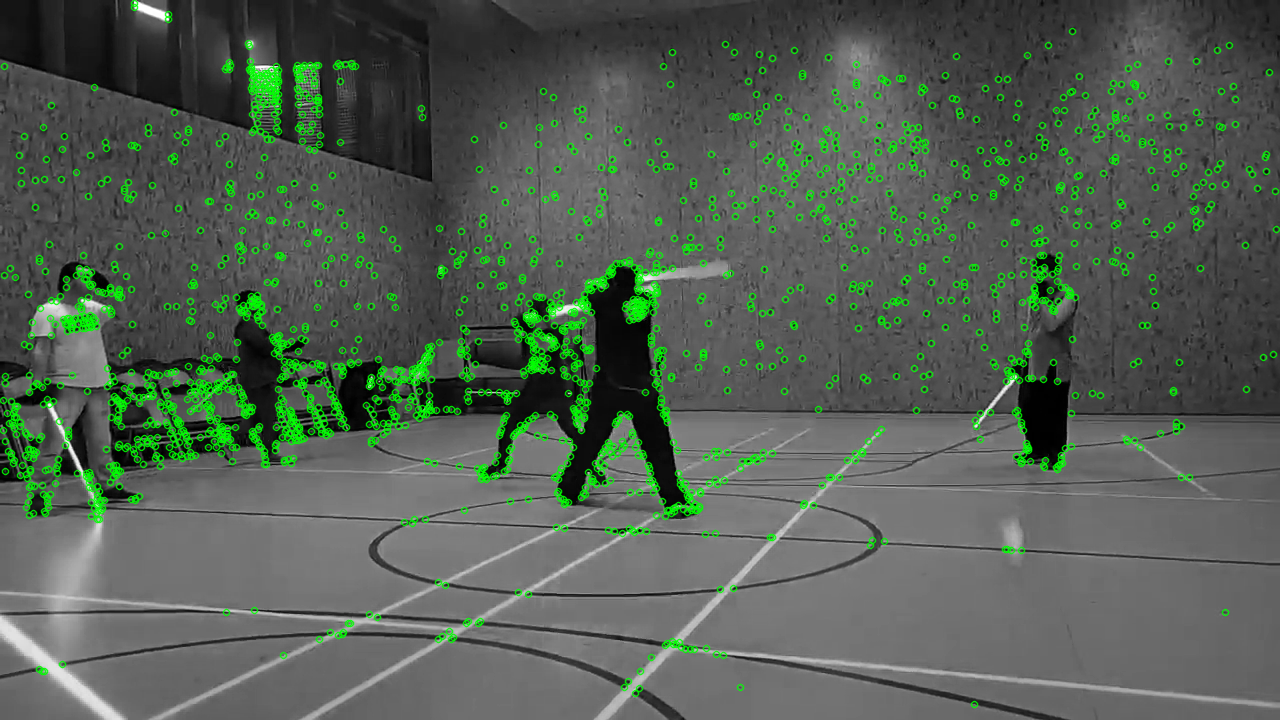

In [12]:
fast = cv2.FastFeatureDetector_create(30)
fast.setNonmaxSuppression(True)
kp = fast.detect(gray, None)

kp_image = cv2.drawKeypoints(gray, kp, None, color=(0, 255, 0))
px.imshow(kp_image)